In [ ]:
'''
  First draft of a recognitiontool for different words
  I used the tensorflow word recognition conv net for this
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [ ]:
#From Tensorflow Tutorial/ Small sample from Speech commands Dataset will be loaded here
data_dir = pathlib.Path('/content/drive/MyDrive/Audifine/Train')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


My Commands arent saved in a Readme or something like this at the moment. So I have to hardcode them here

In [ ]:
commands =  ['Transformer','Neural Network','CNN','Audifine','Spracherkennung','Python','Layers','Preprocessing','Tensorflow','Programmieren']

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)


Commands: ['Transformer' 'Neural Network' 'CNN' 'Audifine' 'Spracherkennung'
 'Python' 'Layers' 'Preprocessing' 'Tensorflow' 'Programmieren']


In [ ]:
#TODO There shouldn't be much difference to my dataset, so I dont have to change a lot

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])


Number of total examples: 4664
Number of examples per label: 726
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/Audifine/Train/CNN/CNN28__Restaurant Ambiance.wav', shape=(), dtype=string)


**Preprocessing and Learning should work the same, so if I can use this code, I don't have to change a lot for the moment**

In [ ]:
train_files = filenames[:1000]
val_files = filenames[1000: 1000 + 200]
test_files = filenames[-200:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


Training set size 1000
Validation set size 200
Test set size 200


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)


In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]


In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


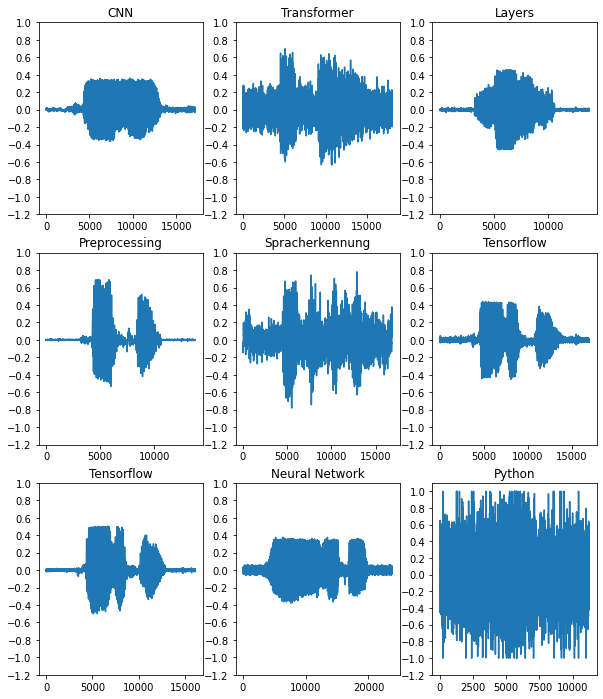

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([32000] - tf.shape(waveform), dtype=tf.float32)
  print(zero_padding)
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  print(equal_length)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=510, frame_step=256)

  spectrogram = tf.abs(spectrogram)

  return spectrogram


In [ ]:
for waveform, label in waveform_ds.take(3):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))


tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(14800,), dtype=float32)
tf.Tensor(
[ 0.00210571  0.00146484 -0.00048828 ...  0.          0.
  0.        ], shape=(32000,), dtype=float32)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(13952,), dtype=float32)
tf.Tensor([0.1008606  0.20489502 0.27368164 ... 0.         0.         0.        ], shape=(32000,), dtype=float32)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(18208,), dtype=float32)
tf.Tensor(
[-0.00213623  0.00570679 -0.0065918  ...  0.          0.
  0.        ], shape=(32000,), dtype=float32)
Label: Layers
Waveform shape: (13792,)
Spectrogram shape: (124, 257)
Audio playback


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


ValueError: ignored

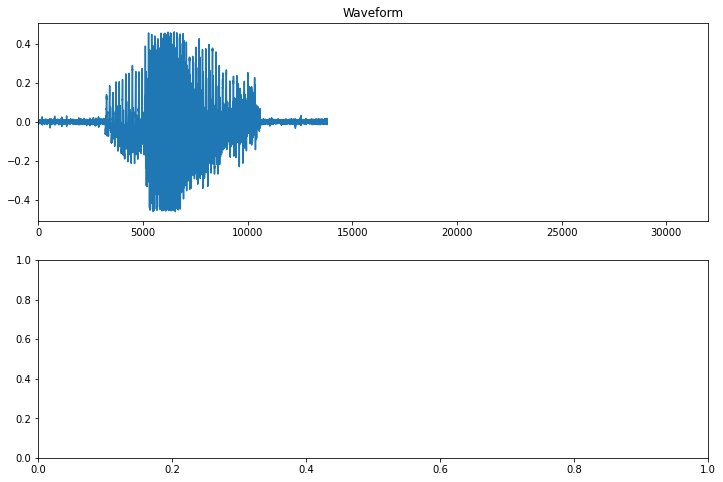

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(32000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 32000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id


In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


Tensor("zeros:0", shape=(None,), dtype=float32)
Tensor("concat:0", shape=(None,), dtype=float32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


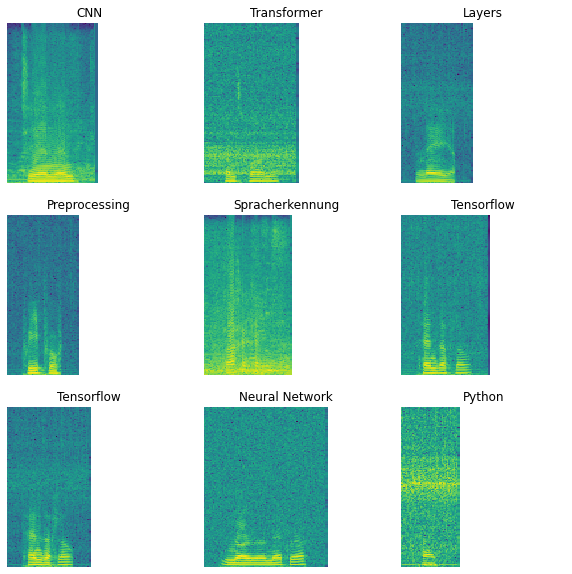

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()


In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds


In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


Tensor("zeros:0", shape=(None,), dtype=float32)
Tensor("concat:0", shape=(None,), dtype=float32)
Tensor("zeros:0", shape=(None,), dtype=float32)
Tensor("concat:0", shape=(None,), dtype=float32)


In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 257, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10
16/16 [==============================] - 25s 2s/step - loss: 2.3718 - accuracy: 0.1398 - val_loss: 2.1254 - val_accuracy: 0.3350
Epoch 2/10
16/16 [==============================] - 3s 210ms/step - loss: 2.0053 - accuracy: 0.3588 - val_loss: 1.6782 - val_accuracy: 0.5450
Epoch 3/10
16/16 [==============================] - 3s 212ms/step - loss: 1.5626 - accuracy: 0.4930 - val_loss: 1.3839 - val_accuracy: 0.6350
Epoch 4/10
16/16 [==============================] - 3s 214ms/step - loss: 1.2567 - accuracy: 0.6289 - val_loss: 1.1894 - val_accuracy: 0.6750
Epoch 5/10
16/16 [==============================] - 3s 212ms/step - loss: 1.0121 - accuracy: 0.7088 - val_loss: 1.0067 - val_accuracy: 0.7350
Epoch 6/10
16/16 [==============================] - 3s 211ms/step - loss: 0.7901 - accuracy: 0.7562 - val_loss: 0.8517 - val_accuracy: 0.7900
Epoch 7/10
16/16 [==============================] - 3s 213ms/step - loss: 0.6475 - accuracy: 0.8068 - val_loss: 0.8495 - val_accuracy: 0.8100
Epoch 8/

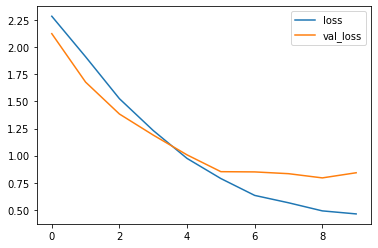

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


Test set accuracy: 79%


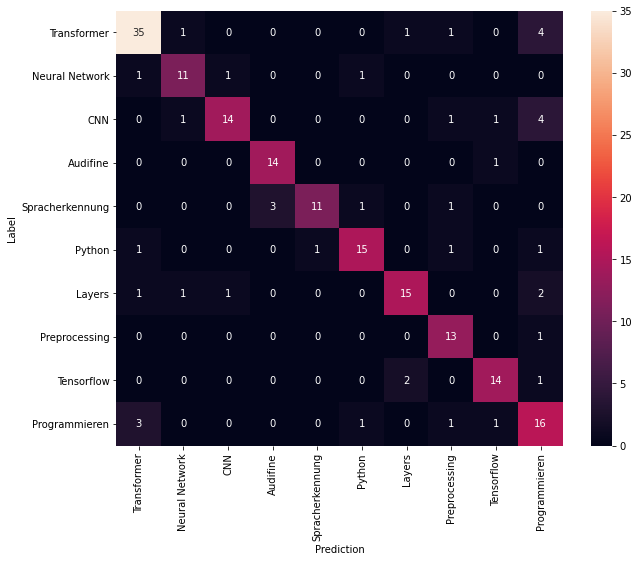

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


Tensor("zeros:0", shape=(None,), dtype=float32)
Tensor("concat:0", shape=(None,), dtype=float32)


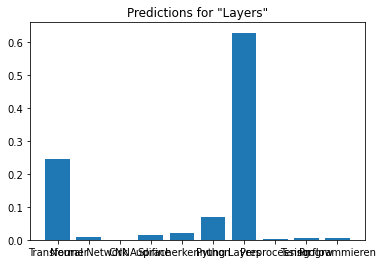

In [ ]:
sample_file = '/content/drive/MyDrive/Audifine/Train/Layers/Layers0__Home-Phone-Ringing.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()
